<a href="https://colab.research.google.com/github/valesierrai/Aprendizaje-No-Supervisado-para-el-AD/blob/main/Parcial_1_VSI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Cargamos Librerias

Description of Columns:

* TYPE: Type of the house.

* PRICE: Price of the house.

* BEDS: Number of bedrooms.

* BATH: Number of bathrooms.

* PROPERTYSQFT: Square footage of the property.

* LATITUDE: Latitude coordinate of the house.

* LONGITUDE: Longitude coordinate of the house.

In [ ]:
from google.colab import drive # conexión con drive
drive.mount('/content/drive')
import pandas as pd # Manejo de Data Frame
import numpy as np # Manejo matricial
import warnings # Omitir warnings
warnings.filterwarnings("ignore") # Ignorar warning (me estresan los warnings >:|)
# librerías para Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Librerías para clustering
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import dendrogram,  linkage # Dendograma
# Score de silueta
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler # estandarizar variables.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Cargamos la Base de Datos

In [ ]:
datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Aprendizaje No Supervisado/NY-House-Dataset.csv")
datos= datos[ datos["PRICE"]< 10**7]
datos=datos[datos["BEDS"] <20]
datos=datos[datos["BATH"] <20]
datos["TYPE"]= datos["TYPE"].replace({"Condop for sale": "Condo for sale",
                                      'Multi-family home for sale': "House for sale",
                                      # "Townhouse for sale":"House for sale",
                                      'Pending':np.nan, 'Contingent':np.nan})
categorias_drop = [ 'Land for sale', 'For sale', "House for sale",
                   'Foreclosure', 'Coming Soon',
                   'Mobile house for sale',"Townhouse for sale"]
datos["TYPE"] = datos["TYPE"].replace( categorias_drop, "Other")
datos = datos[~datos["TYPE"].isin(categorias_drop)]

#2. Organizamos la Base de Datos

In [ ]:
datos.shape

(4628, 17)

In [ ]:
datos.isna().sum()

,0
BROKERTITLE,0
TYPE,327
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
ADDRESS,0
STATE,0
MAIN_ADDRESS,0
ADMINISTRATIVE_AREA_LEVEL_2,0


In [ ]:
datos=datos.dropna()
datos.shape

(4301, 17)

En un principio se tenian (4628, 17), pero se encontraron 327 datos faltantes en la columna "Type". Entonces se eliminaron, y quedaron (4301, 17).

#3. Se Organizan y se Analizan las Variables

In [ ]:
datos.columns

Index(['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT',
       'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2',
       'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME',
       'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [ ]:
#Dejamos en la base de datos solo aquellas variables que nos sirven para este caso
data= datos.drop(labels=['BROKERTITLE',
       'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2',
       'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME',
       'FORMATTED_ADDRESS'], axis=1)
data.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
0,Condo for sale,315000,2,2.0,1400.000000,40.761255,-73.974483
2,Other,260000,4,2.0,2015.000000,40.541805,-74.196109
3,Condo for sale,69000,3,1.0,445.000000,40.761398,-73.974613
5,Other,690000,5,2.0,4004.000000,40.674363,-73.958725
6,Condo for sale,899500,2,2.0,2184.207862,40.809448,-73.946777


In [ ]:
#Se crea la variable "Precio por cada metro cuadrado"
data["PRICE_M2"]= data["PRICE"]/data["PROPERTYSQFT"]
data.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE_M2
0,Condo for sale,315000,2,2.0,1400.000000,40.761255,-73.974483,225.000000
2,Other,260000,4,2.0,2015.000000,40.541805,-74.196109,129.032258
3,Condo for sale,69000,3,1.0,445.000000,40.761398,-73.974613,155.056180
5,Other,690000,5,2.0,4004.000000,40.674363,-73.958725,172.327672
6,Condo for sale,899500,2,2.0,2184.207862,40.809448,-73.946777,411.819779


In [ ]:
#Se crea la variable del nñumero total de habitaciones y baños
data["BEDS_BATH"]= data["BEDS"]+data["BATH"]
data["BEDS_BATH"]

,BEDS_BATH
0,4.0
2,6.0
3,4.0
5,7.0
6,4.0
...,...
4796,2.0
4797,2.0
4798,2.0
4799,3.0


In [ ]:
data.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE_M2,BEDS_BATH
0,Condo for sale,315000,2,2.0,1400.000000,40.761255,-73.974483,225.000000,4.0
2,Other,260000,4,2.0,2015.000000,40.541805,-74.196109,129.032258,6.0
3,Condo for sale,69000,3,1.0,445.000000,40.761398,-73.974613,155.056180,4.0
5,Other,690000,5,2.0,4004.000000,40.674363,-73.958725,172.327672,7.0
6,Condo for sale,899500,2,2.0,2184.207862,40.809448,-73.946777,411.819779,4.0


In [ ]:
data.columns

Index(['TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE',
       'LONGITUDE', 'PRICE_M2', 'BEDS_BATH'],
      dtype='object')

In [ ]:
#Dejamos solo las variables con las que vamos a trabajar
data1= data.drop(labels=['BEDS', 'BATH'], axis=1)
data1.head()

,TYPE,PRICE,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE_M2,BEDS_BATH
0,Condo for sale,315000,1400.000000,40.761255,-73.974483,225.000000,4.0
2,Other,260000,2015.000000,40.541805,-74.196109,129.032258,6.0
3,Condo for sale,69000,445.000000,40.761398,-73.974613,155.056180,4.0
5,Other,690000,4004.000000,40.674363,-73.958725,172.327672,7.0
6,Condo for sale,899500,2184.207862,40.809448,-73.946777,411.819779,4.0


In [ ]:
data1.describe()

,PRICE,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE_M2,BEDS_BATH
count,4.301000e+03,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000
mean,1.274293e+06,2008.850473,40.716141,-73.936609,652.794973,5.435445
std,1.451674e+06,1847.636996,0.087801,0.099353,555.059488,3.264554
min,2.494000e+03,230.000000,40.499798,-74.253033,1.141833,2.000000
25%,4.788880e+05,1160.000000,40.640711,-73.984097,320.000000,3.000000
50%,7.990000e+05,2184.207862,40.727821,-73.944271,480.265646,5.000000
75%,1.395000e+06,2184.207862,40.773647,-73.864809,781.059948,7.000000
max,9.999000e+06,55300.000000,40.912729,-73.702450,4685.792350,32.000000


Se escogieron las variables: 'PRICE_M2' y 'BEDS_BATH'.

**PRICE_M2:** En esta variable podemos ver que el precio promedio de las casas es de $652.794973, y que al tener una desviación muy grande (555.059488), esto nos da a entender que los precios de las casas por cada metro cuadrado fluctuan muy alejados de la media. Además, podemos decir que el precio por metro cuadrado minímo es de 1.141833 dólares, teniendo como precio máximo 4685.792350 dolares.

**BEDS_BATH:** Con respecto a esta variable, podemos decir que el promedio de baños y habitaciones de las casas del mercado inmobiliario de Nueva York es de 5. Donde el número total de baños y habitaciones, se mueve en un rango de (2,32). Este último dato, a pesar de significar que una casa cuenta con una suma de 32 habitaciones y baño, no lo consideramos atípico, pues puede tratarse de una casa muy grande dentro de Nueva York.  

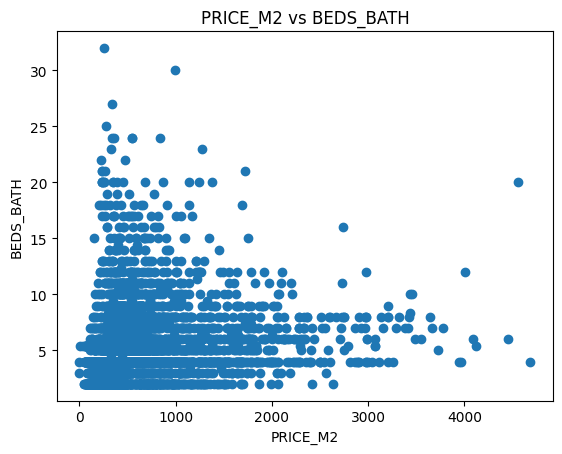

In [ ]:
#Gráfico
plt.scatter(x=data1["PRICE_M2"],y=data1["BEDS_BATH"])
plt.xlabel("PRICE_M2")
plt.ylabel("BEDS_BATH")
plt.title("PRICE_M2 vs BEDS_BATH")
plt.show()

Según el gráfico, podemos ver que por lo general entre menor sea el precio, la cantidad de habitaciones y de baños también es menor. Teniendo este una conecntración de datos muy grande en la esquina inferior izquierda. No obstante, podemos ver que hay datos que se salen de esta tendencia, teniendo un precio bajo, pero un total de baños y de habitaciones alto. Por otro lado, vemos que también existen casas que tienen un precio alto ($4000 o superior), que tambien tienen una menor cantidad de baños (0,5).

Es por esto, que si bien el precio puede depender de la cantidad de baños y de habitaciones que tenga, podemos ver que en algunos casos esto no aplica, sino que el precio está determinado por otra variable, en esta caso podría ser la locación del inmueble.

#4. Transformación y Estandarización de Variables

In [ ]:
variables_cc=['TYPE', 'PRICE', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE', 'PRICE_M2','BEDS_BATH']
print("Cantidad de variables", len(variables_cc))

Cantidad de variables 7


In [ ]:
#Cambiamos la variable "TYPE" a dummy
datos_numericos = pd.get_dummies(data1[variables_cc], ['TYPE' ],)

In [ ]:
datos_numericos

,PRICE,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE_M2,BEDS_BATH,TYPE_Co-op for sale,TYPE_Condo for sale,TYPE_Other
0,315000,1400.000000,40.761255,-73.974483,225.000000,4.0,False,True,False
2,260000,2015.000000,40.541805,-74.196109,129.032258,6.0,False,False,True
3,69000,445.000000,40.761398,-73.974613,155.056180,4.0,False,True,False
5,690000,4004.000000,40.674363,-73.958725,172.327672,7.0,False,False,True
6,899500,2184.207862,40.809448,-73.946777,411.819779,4.0,False,True,False
...,...,...,...,...,...,...,...,...,...
4796,599000,2184.207862,40.774350,-73.955879,274.241298,2.0,True,False,False
4797,245000,2184.207862,40.732538,-73.860152,112.168812,2.0,True,False,False
4798,1275000,2184.207862,40.745882,-74.003398,583.735652,2.0,True,False,False
4799,598125,655.000000,40.742770,-73.872752,913.167939,3.0,False,True,False


In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(datos_numericos)
pd.DataFrame(scaled_features, columns = datos_numericos.columns)

#5. Implementación del Modelo: K-Means

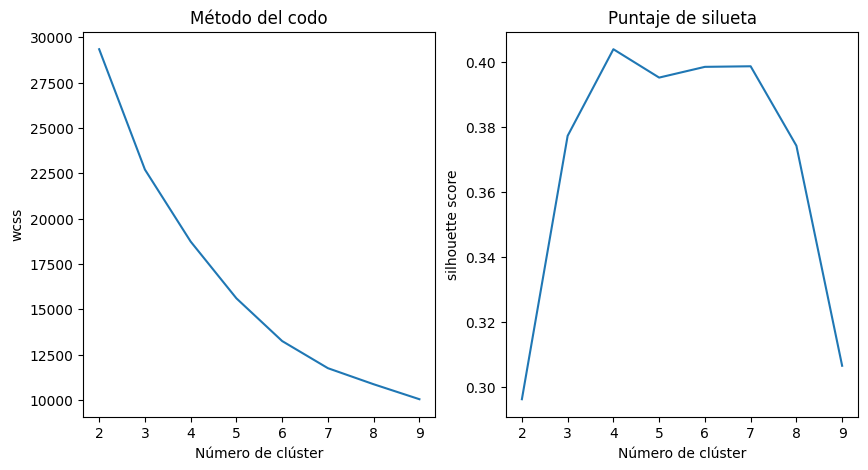

In [ ]:
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k)
  k_means.fit(scaled_features)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

Según los métodos implementados para saber el número apropiado de clústers podemos decir que basandonos en el *método del codo*, no hay un "codo" muy marcado, sin embargo podemos notar un breve "codo" en el 6, indicando que este sería el número apropiado de clústers.

Por otro lado, cuando miramos el *puntaje de silueta*, podriamos decir que el máximo se dá en el 4.

Ahora, mezclando ambos métodos, si analizamos el punto 4 en el método del codo, nos damos cuenta que no hay ningún cambio notorio o "codo". Asimismo, probamos el punto 6 en puntaje de silueta, y en este logramos ver un breve pico, siendo este uno de los puntos más altos del gráfico. Es por esta razón que el número de clústers sería **6**. No obtante vamos a mirar la distribución de los datos a ver si la elección es mejor cambiarla.

In [ ]:
#Si escogieramos 4
k_means=KMeans(4, random_state=123  )
k_means.fit(scaled_features )
data1["labels_k_means"]= k_means.labels_
data1["labels_k_means"] = data1["labels_k_means"].astype(str)
data1["labels_k_means"].value_counts()

,count
labels_k_means,
0,1904
1,1362
3,757
2,278


In [ ]:
#Si escogieramos 6
k_means=KMeans(6, random_state=123  )
k_means.fit(scaled_features )
data1["labels_k_means"]= k_means.labels_
data1["labels_k_means"] = data1["labels_k_means"].astype(str)
data1["labels_k_means"].value_counts()

,count
labels_k_means,
1,1362
0,1145
4,773
3,754
2,263
5,4


Viendo la distribución de los datos si bien arriba habiamos dicho que 6 clústers sería el número de clústers indicado. Podríamos decir que al tener en un clúster tan solo 4 datos podría afectarnos el análisis pues son muy pocos datos para tomar en cuenta. Mientras, que si utilizamos 4 clústers, al tener una distribución un poco más pareja, podríamos tener un análisis mejor. Por ende, yo no escogería no escogería 6 clústers sino 4.

#6. Implementación del Modelo: Clúster Jerárquico

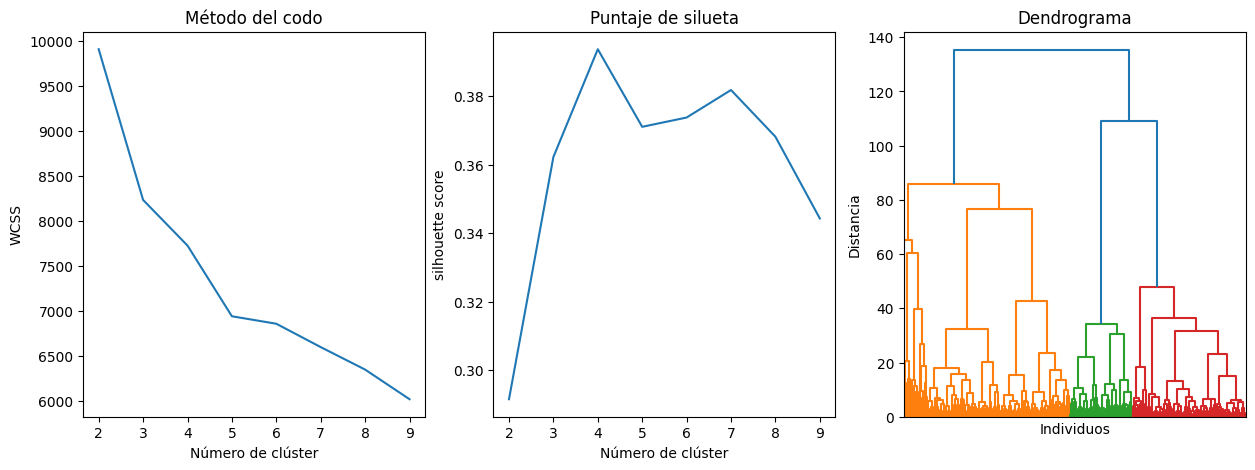

In [ ]:
silueta =[]
wcss =[]
n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(scaled_features)
  scaled_temp= pd.DataFrame(scaled_features)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(scaled_features,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )

# visualización clustering jerarquico
dist_matrix = linkage(scaled_features, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

Según los métodos aplicados para saber el número de clústers apropaido podemos decir que según el *método del codo*, vemos dos codos marcados, en los números 3 y 5. Por otro lado, en el *puntaje de silueta* vemos que el punto máximo es en el punto 4. Finalmente, fijandono en el *dendograma* el número apropiado de clústers sería entre (3,5).

Ahora, analizando los puntos obtenido en cada uno de los métodos, vemos que si analizamos el punto 4. Vemos que si bien no hay un codo muy marcado en este punto, en el punto sí existe un leve codo. Ahora, mirando los números 3 y 5, vemos que en punto 3 tenemos un punto alto pero con una punta leve, mientras que en el 5 vemos una disminución notoria, lo que descartaría este número como el apropiado.

En conclusión mirando los tres métodos el número apropiado de clústers sería **4**.

In [ ]:
#Si escojo 4
hc=AgglomerativeClustering(4)
hc.fit(scaled_features )
data1["labels_hc"]= hc.labels_
data1["labels_hc"] = data1["labels_hc"].astype(str)
data1["labels_hc"].value_counts()

,count
labels_hc,
0,1798
3,1420
2,784
1,299


##**Se interpretan los datos**

In [ ]:
print(data1["labels_hc"].value_counts(normalize=True))
px.bar(data1["labels_hc"].value_counts(normalize=True),
       title="Frecuencia Clústers")

labels_hc
0    0.418042
3    0.330156
2    0.182283
1    0.069519
Name: proportion, dtype: float64


Analizando la frecuencia de los clústers podemos, decir que el clúster con mayor frecuencia es el 0 con 41.80%, seguido del 3 con 33.01%. Y que los clústers con menos frecuencia son el 2 con 18.22% y el 1 con 6.95%.

In [ ]:
#Descripción de la Ubicación
px.scatter( data1,x='LATITUDE', y='LONGITUDE', color= 'labels_hc'  )

Con base a la ubicación no observamos una agrupación específica, siendo los clúster 0 y 2 los que están más esparcidos con respecto al resto de clústers. Ahora, analizando el clúster 3, notamos una agrupación de los datos hacia el este, específicamente en el norte. Asimismo, el clúster 1, muestra una tendencia de estar ubicados en noreste, estando un poco más centrados.


In [ ]:
#Descripción de la variable 'TYPE'
tabla1 = data1.groupby('labels_hc')['TYPE'].value_counts(normalize=True)
px.bar(tabla1.reset_index(), x='labels_hc',y="proportion" , color='TYPE', barmode='group')

Según el clúster 0, se nota una preferencia por los tipos de casa "Other" los cuales incluyen 'Land for sale', 'For sale', "House for sale",'Foreclosure', 'Coming Soon', 'Mobile house for sale',"Townhouse for sale". Por otro lado, en el clúster 1 notamos que no hay una preferencia específica por algún tipo de casa, pero predomina la elección de casas diferentes a 'Condo for sale' y 'Co-op for sale'.
Mirando los clústers 2 y 3, vemos que en ambos hay una preferencia específica, donde el 2 prefiere 'Condo for sale' y el clúster 3 'Co-op for sale'.

In [ ]:
px.box(data1, x='labels_hc', y='BEDS_BATH',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='BEDS_BATH: Boxplot por clúster')

Con respecto a esta variable que me suma la cantidad de baños y de habitaciones, podemos notar que el clúster 1 es el que tiene mayor variabilidad con respecto al resto de los clústers. De la misma manera es el que cuenta con un promedio mayor al resto de clúster, el cual es de 9 habitaciones y baños en un inmueble. Seguido de este clúster está el clúster 0, que tiene un promedio de 6 baños y habitaciones los cuales se mueven en un rango interucartil de (5,8).

Por otro lado, tenemos al clúster 2, el cual tiene una media de 4 habitaciones y baños por inmueble.

Caso contrario es el que ocurre con el clúster 3, pues este apenas tiene un promedio 3 habitaciones y baños.

#Análisis por Clúster:

##**Clúster 0:**

*Frecuencia:* Alta, 41.80% (mayor de todos)

*Ubicación:* Muy dispersa, esparcida por todas partes.

*Type of House:* Preferencia por otros tipos de casa diferentes a 'Condo for sale' y 'Co-op for sale'.

*BEDS_BATH:* 6 habitaciones y baños en promedio, con un rango intercuartil de (5,8).

##**Clúster 1:**

*Frecuencia:* Baja, 6.95% (menor que todos)

*Ubicación:* Centrada, con inclinación hacia el noreste.

*Type of House:* Preferencia por otros tipos de casa diferentes a 'Condo for sale' y 'Co-op for sale'.

*BEDS_BATH:* 9 habitaciones y baños por inmueble (mayor que el resto de clúster).

##**Clúster 2:**

*Frecuencia:* Relativamente Baja, 18.22%

*Ubicación:* Muy dispersa, esparcida por todas partes.

*Type of House:* Preferencia por 'Condo for sale'.

*BEDS_BATH:* 4 habitaciones y baños en promedio.

##**Clúster 3:**
*Frecuencia:* Relativamente Alta, 33.01%

*Ubicación:* Tendencia de estar ubicados en el noreste.

*Type of House:* Preferencia por 'Co-op for sale'.

*BEDS_BATH:* 3 habitaciones y baños en promedio (menor que todos los clústers).




Se realiza esta gráfica para el análisis general

In [ ]:
px.box(data1, x='labels_hc', y='PRICE',color="labels_hc",
      #  points=False, # No muestra los puntos atípicos extendiendo las barras
             title='PRICE: Boxplot por clúster')

#7. Conclusión General

Con base a los 4 clústers implementados según el algoritmo del Clústering Jerárquico, podemos decir que con respecto a la variables analizadas (ubicación, tipo de casa y cantidad de baños y habitaciones), la información que tenemos de cada clúster es muy distinta, lo que ayudará a la empresa a generar estrategías específicas para maximizar las ventas con respecto al tipo de clientes.

Ahora, si seleccionamos el **clúster 3**, el cual contiene una frecuencia de datos significativa para el mercado, ya que es muy alta con el 33.01% de los clientes. Podemos ver que  estan generalmente ubicados en el noreste de Nueva York, el cual los inmuebles elegidos suelen ser 'Co-op for sale' con un promedio de 3 habitaciones y baños por inmueble. Ahora, fijandonos en el precio promedio de estas casas es bajo ($418.944k) con respecto al resto de clústers.

Teniendo en cuenta esto, si la empresa se fija en estas preferencias y/o tendencias de este tipo de clientes en el mercado inmobiliario de Nueva York, podría generar una estrategia de casas económicas en el sector noreste de este estado, de tipo 'Co-op for sale' para aumentar las ventas. Creando ya sea una campaña publicitaria de este tipo de inmueble, o una feria inmobiliaria enfocada a este estilo de clientes.